# Gaussian density estimation

Our goal is to recover the density $\psi(x) = \mathcal{N}(x; 0, I)$ given samples $\{x_i\}_{i=1}^{n}$ such that $x_i$ are sampled from the two dimensional Gaussian distribution (e.g., $x_i \sim \mathcal{N}(0, I)$). 

We also are interested in finding solutions to differential equations of the form $\mathcal{L}_{c, \psi} f = g$, where 
$$
    \mathcal{L}_{c, \psi} f = \Delta f + c \nabla f \cdot \frac{\nabla \psi}{\psi}
$$
is an elliptic Kolmogorov operator. Here, $c \in \mathbb{R}$ is a parameter, $\Delta$ is the Laplace-Beltrami operator, and $\nabla$ is the gradient operator.

Evaluating exponentially decaying kernels of the form $K(\epsilon, x, y) = K(\|x-y\|^2/\epsilon^2)$ on pairs of points $x, y \in \Omega \subseteq \mathbb R^m$ allows us to approximate geometric operators for functions defined over a manifold $\Omega$. Define the integral operator 
$$
    \mathcal{I}_{\epsilon} f(x) = \int_{\Omega} \widetilde K(\epsilon, x, x^{\prime}) f(x^{\prime}) \psi(x^{\prime}) \, d x^{\prime} \approx \sum_{i=1}^{n} \widetilde K(\epsilon, x, x^{(i)}) f(x^{(i)}),
$$
where $\widetilde K $ is a kernel constructed by a normalization (e.g., Markov normalization) of $K$, $\psi$ is a probability density function defined on $\Omega$, and $x^{(i)} \sim \psi$. Intuitively, the exponential decay of the kernel localizes this integral in an $\epsilon$-ball around $x$. For small $\epsilon$, we have the asymptotic expansion in the form of a Taylor series
$$
    \mathcal{I}_\epsilon f(x) = m_\psi(x)f(x)  + \epsilon^2 \mathcal{L}_{\psi} f(x) + O(\epsilon^4),
$$
where $m_\psi$ is a function and  $\mathcal{L}_{\psi}$ is a second-order differential operator that may depend on the density $\psi$ and the normalization of the kernel. We will use this Taylor series to estimate the density $\psi$ and solutions to the Kolmogorov problem given samples.

References:
- <a href="https://www.sciencedirect.com/science/article/pii/S1063520315000020">"Variable bandwidth diffusion kernels" by T. Berry & J. Harlim</a>
- <a href="https://www.sciencedirect.com/science/article/pii/S1063520317300982">"Data-driven spectral decomposition and forecasting of ergodic dynamical systems" by D. Giannakis</a>
- <a href="https://arxiv.org/abs/2104.15124">"Graph-theoretic algorithms for Kolmogorov operators: Approximating solutions and their gradients in elliptic and parabolic problems on manifolds" by A.D. Davis & D. Giannakis</a>

In [1]:
# load the MUQ libraries
import muq.Modeling as mm
import muq.SamplingAlgorithms as sa

# numpy for linear algebra on the Python side
import numpy as np

# import plotting packages and set default figure options
useserif = False # use a serif font with figures?
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
if useserif:
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['text.usetex'] = True
else:
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

First, sample a two dimensional Gaussian to get $\{x^{(i)}\}_{i=1}^{n}$ and create the object that we will use to estimate the probability density function $\psi(x)$ and the Kolmogorov operator $\mathcal{L}_{c, \psi}$.

In [2]:
n = 10000 # the number of samples 
knn = 26 # the number of nearest neighbors for the bandwidth function

def CreateDensityEstimate():
    # the Gaussian random variable we will sample
    rv = mm.Gaussian(2).AsVariable()

    # create the density estimate
    options = dict()
    options["NumSamples"] = n
    options["NumNearestNeighbors"] = knn
    options["ManifoldDimension"] = 2
    options["NumThreads"] = 8
    options["Stride"] = int(3*np.log(n))
    options["SparsityTolerance"] = 1.0e-4
    options["NumEigenpairs"] = 100
    densEstimate = sa.KolmogorovOperator(rv, options)
    return densEstimate

# create the density estimate 
kolmogorov = CreateDensityEstimate()
assert(kolmogorov.NumSamples()==n)

## Density estimation

We first estimate the probability density function $\psi$. Define the bandwidth function 
$$
    b^2(x) = \sum_{k=1}^{k_{nn}} \| x - x^{(I(x,k))} \|^2,
$$
where $k_{nn}$ is an integer parameter that determines a local neighborhood centered at $x$ and $I(x,k)$ is the $k^{th}$ closest sample to $x$. We use the convention that $I(x^{(i)},0)=i$. Let $\epsilon$ be the bandwidth parameter and define the kernel matrix $\boldsymbol{K}_{\epsilon} \in \mathbb{R}^{n \times n}$ with entries 
$$
    K_{\epsilon}^{(ij)} = \exp{\left( - \frac{\| x^{(i)} - x^{(j)} \|^2}{\epsilon^2 b(x^{(i)}) b(x^{(j)})} \right)},
$$
which is a variable-bandwidth kernel. Since the entries decay exponentially with square distance $\|x^{(i)} - x^{(j)} \|^2$, we typically truncate by setting $K_{\epsilon}^{(ij)} = 0$ if the entry is sufficiently small---this defines a large, but sparse, matrix. 

Performing a kernel normalization and applying the associated integral operator $\mathcal I_\epsilon$ to a constant function approximates the probability density function $\psi$. In the discrete case, a suitable normalizing function for density estimation is given by
$$
    w(x) = n (\pi \epsilon^2 b(x)^2)^{d/2}. 
$$
This leads to the normalized kernel
$$
\widetilde K_b(\epsilon,x^{(i)}, x^{(j)}) = \frac{K_{\epsilon}^{(ij)}}{w(x^{(i)})}  ,
$$
and the density estimate
$$
    \hat\psi(x) = \sum_{i=1}^n \widetilde K_b(\epsilon,\boldsymbol x, \boldsymbol x^{(i)} ) \approx \mathcal I_\epsilon 1,
$$
where we have approximated the integral operator applied to the constant function $f(x) = 1$. Evaluating the density estimate at the sample points becomes a matrix-vector product by defining a diagonal normalizing matrix $W$ with entries $W^{(ii)} = w(x^{(i)})$, i.e.,
$$
    \psi = W^{-1} K_{\epsilon} 1,
$$
where $\psi = ( \hat \psi(x^{(1)}), \ldots, \hat \psi(x^{(n)})^\top $. 

## Aside: Bandwidth parameter tuning

Choosing the parameter $\epsilon$ is very important and we, therefore, use automatic tuning procedures. Let $\xi \in \mathbb{R}$ parameterize the bandwidth parameter $\epsilon_{\xi}^2 = 2^{\xi}$, and define
$$
    \chi_{\xi} = \displaystyle\sum_{i,j=1}^{n} K_{\epsilon_{\xi}}^{(ij)}\quad \mbox{and}, \quad \chi_{\xi, \beta} = \sum_{i,j=1}^{n} K_{\epsilon_{\xi}, \beta}^{(ij)}.
$$
The optimal bandwidth parameters for the density estimation and operator estimation procedures maximize
$$
    \chi_{\xi}^{\prime} = \frac{\log{(\chi_{\xi+\delta})}-\log{(\chi_{\xi})}}{\delta \log{(2)}} \quad \mbox{and} \quad  \chi_{\xi, \beta}^{\prime} = \frac{\log{(\chi_{\xi+\delta, \beta})}-\log{(\chi_{\xi, \beta})}}{\delta \log{(2)}},
$$
respectively. The maximum values of $\chi^{\prime}_\xi$ and $\chi^{\prime}_{\xi,\beta}$ approximate the intrinsic dimension of the manifold $\Omega$. 

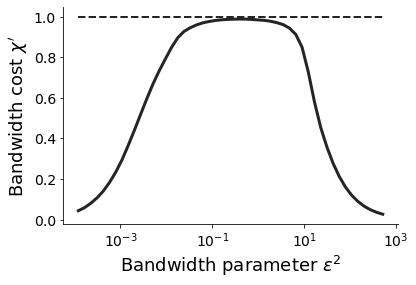

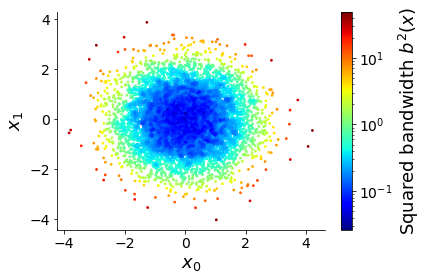

In [3]:
def PlotSquaredBandwidth():   
    # compute the squared bandwidth at each sample 
    samples = [None]*n
    squaredBandwidth = [1.0]*n
    for i in range(n):
        samples[i] = kolmogorov.Point(i)
        squaredBandwidth[i] = kolmogorov.SquaredBandwidth(samples[i], knn)
    samples = np.array(samples).T
    
    # the cost function used to tune the density bandwidth parameter 
    ell = np.linspace(-13.0, 9.0, num=50)
    bandwidthParameter = [None]*len(ell)
    cost = [None]*len(ell)
    for i in range(len(ell)):
        bandwidthParameter[i] = np.sqrt(2.0**ell[i])
        cost[i] = kolmogorov.BandwidthParameterCost(np.sqrt(squaredBandwidth), bandwidthParameter[i])
        
    # plot the bandwidth tuning cost
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    ax.plot([bandwidthParameter[0]**2.0, bandwidthParameter[-1]**2.0], [1.0, 1.0], '--', linewidth=2, color='#252525')
    ax.semilogx(np.square(bandwidthParameter), cost, linewidth=3, color='#252525')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'Bandwidth parameter $\epsilon^2$')
    ax.set_ylabel(r'Bandwidth cost $\chi^{\prime}$')
    plt.show()
        
    # plot the squared bandwidth
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=squaredBandwidth, 
                         norm=mcolors.LogNorm(), vmin=min(squaredBandwidth), 
                         vmax=max(squaredBandwidth), cmap='jet')
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Squared bandwidth $b^2(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()

PlotSquaredBandwidth()

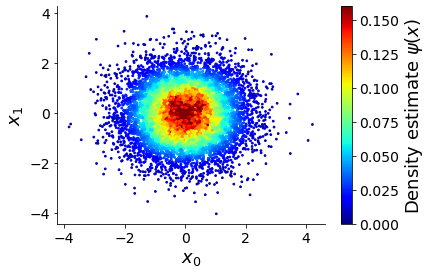

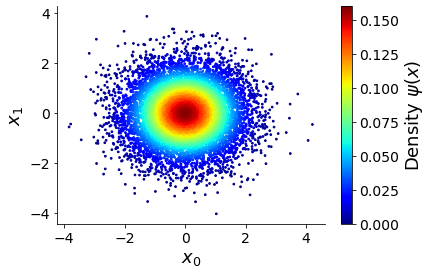

In [4]:
def EstimateGaussianDensity():
    estimate = kolmogorov.EstimateDensity()
    
    # the Gaussian random variable we will sample
    dens = mm.Gaussian(2).AsDensity()
    
    # compute the samples (this is a little redundant, but saves us having to store the samples as a variable)
    samples = [None]*n
    trueDensity = [None]*n
    for i in range(n):
        samples[i] = kolmogorov.Point(i)
        trueDensity[i] = np.exp(dens.LogDensity(np.array(samples[i])))
    samples = np.array(samples).T
    
    # plot the density estimate
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=estimate, vmin=0.0, vmax=0.16, cmap='jet')
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Density estimate $\psi(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
    # plot the true density 
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=trueDensity, vmin=0.0, vmax=0.16, cmap='jet')
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Density $\psi(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
    return estimate
    
densityEstimate = EstimateGaussianDensity()

## Compute the eigenspectrum of the discrete Kolmogorov operator

Given the density estimate $\hat \psi $ and a real parameter $\beta$, define the variable-bandwidth kernel matrix $\boldsymbol{K}_{\epsilon,\beta} \in \mathbb{R}^{n \times n}$ with entries
$$
    K_{\epsilon,\beta}^{(ij)} = K_{\hat \psi}(\epsilon, x^{(i)}, x^{(j)}) := \exp{\left( - \frac{\| x^{(i)} - x^{(j)} \|^2}{4 \epsilon^2 (\hat \psi(x^{(i)} ) \hat \psi(x^{(j)}) )^{\beta}} \right)}
$$
and normalizing function $q_{\epsilon, \beta} : \Omega \to \mathbb R^+ $ such that
$$
    q_{\epsilon,\beta}(x) = \frac{1}{ \hat \psi^{\beta d}(x)} \sum_{j=1}^{n} K_{\hat \psi}(\epsilon, x,x^{(j)}).
$$
We note that the bandwidth parameter $\epsilon$ need not be the same as the bandwidth parameter in the density estimation. Again, we typically set $K_{\epsilon, \beta}^{(ij)} = 0$ if the corresponding entry is below a prescribed threshold so that $K_{\epsilon, \beta}$ is sparse. In the special case when $\beta = 0$, $K_{\epsilon, \beta}$ simplifies to a fixed-bandwidth kernel matrix. 

Next, define the normalized variable-bandwidth kernel given another real parameter $\alpha$
$$
    \tilde K_{\hat\psi,\beta,\alpha}( \epsilon, x, y ) = \frac{K_{\hat \psi}(\epsilon,x, y)}{(q_{\epsilon, \beta} (x)q_{\epsilon,\beta}(y))^\alpha}
$$
and an additional normalizing function $q_{\epsilon, \beta, \alpha} : \Omega \to \mathbb R^+$ such that
$$
    q_{\epsilon, \beta, \alpha}(x) = \sum_{j=1}^{n} \tilde K_{\hat \psi, \beta, \alpha}(\epsilon, x, x^{(j)}).
$$
Let  $\boldsymbol{K}_{\epsilon,\beta,\alpha} \in \mathbb{R}^{n \times n} $ be the normalized kernel matrix with entries
$$
    K_{\epsilon,\beta,\alpha}^{(ij)} = \tilde K_{\hat \psi,\beta,\alpha}(\epsilon, x^{(i)}, x^{(j)}),
$$
and let $P$, $D$ be $n \times n$ diagonal matrices such that $P^{(ii)} = \hat \psi^\beta(x^{(i)}) $ and $D^{(ii)} = q_{\epsilon, \beta, \alpha}(x^{(i)})$. Berry and Harlim (2016) show that the matrix 
$$
    L_{\psi, c} = \epsilon^{-2} P^{-2} (D^{-1} K_{\epsilon, \beta, \alpha} - I)
$$
approximates the Kolmogorov operator $\mathcal L_{\psi, c}$ with $c = 2 - 2 \alpha + d \beta + 2 \beta$, in the sense that  
$$
    (L_{\psi, c} f)^{(i)} \approx \mathcal L_{\psi, c} f(x^{(i)}).
$$
The approximation converges in a limit of $\epsilon \to 0 $ after $n \to \infty $ (or for an appropriate decreasing sequence $\epsilon_n$) for fixed $ f \in C^3(\Omega)$ and $\bm x^{(i)} \in \Omega$. 


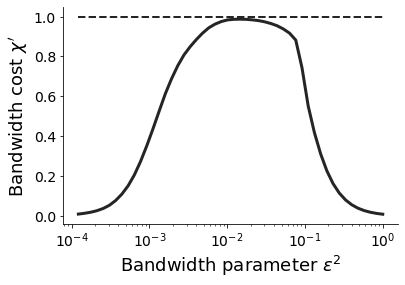

In [6]:
def PlotBandwidthParameterCost():
    # the cost function used to tune the density bandwidth parameter 
    ell = np.linspace(-11.0, 2.0, num=50)
    bandwidthParameter = [None]*len(ell)
    cost = [None]*len(ell)
    for i in range(len(ell)):
        bandwidthParameter[i] = 2.0**ell[i]
        cost[i] = kolmogorov.BandwidthParameterCost(np.power(densityEstimate, kolmogorov.beta), bandwidthParameter[i])
        bandwidthParameter[i] = bandwidthParameter[i]/4.0

    # plot the bandwidth tuning cost
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    ax.plot([bandwidthParameter[0], bandwidthParameter[-1]], [1.0, 1.0], '--', linewidth=2, color='#252525')
    ax.semilogx(bandwidthParameter, cost, linewidth=3, color='#252525')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'Bandwidth parameter $\epsilon^2$')
    ax.set_ylabel(r'Bandwidth cost $\chi^{\prime}$')
    plt.show()

PlotBandwidthParameterCost()

For the purposes of this work, we are interested in approximating the eigenvalues and  eigenfunctions of $\mathcal L_{\psi, c}$ by the eigenvalues and eigenvectors of $L_{\psi,c}$, i.e.
$$
    L_{\psi,c} \phi_j = \hat \lambda_j \phi_j.
$$
We take advantage of specialized solvers by working with the symmetric matrix 
$$    
    \hat{L}_{\psi, c} = \epsilon^{-2} (S^{-1} K_{\epsilon, \beta, \alpha} S^{-1} - P^{-2}),
$$
where $S = P D^{1/2}$ is a diagonal matrix. One can readily verify that $\hat{L}_{\psi, c}$ and $L_{\psi, c}$ are related by the similarity transformation $\hat{L}_{\psi, c} = S L_{\psi, c} S^{-1}$. Therefore, if $\hat{\phi}_j$ is an eigenvector of $\hat{L}_{\psi,c}$ at eigenvalue $\hat \lambda_j$, then $\phi_j = S^{-1} \hat{\phi}_j$ is an eigenvector of $L_{\psi, c}$ at the same eigenvalue. The symmetry of $\hat{L}_{\psi, c}$ implies that the eigenvectors $\hat{\phi}_j$ can be chosen such that $\hat{\phi}_i^\top \hat{\phi}_j = n \delta_{ij}$. This normalization implies that the $\hat{\phi}_i$ are orthonormal with respect to the empirical sampling measure of the data, which approximates the density $\psi$. The eigenvectors of $L_{\psi,c}$ are then orthonormal with respect to the weighted inner product 
$$
    \langle f, g \rangle_{S} := f^\top S^2 g / n,
$$
which approximates the inner product of $\mathcal H_{\psi,c}$. That is, our numerical eigenvectors satisfy $ \langle \phi_i,  \phi_j \rangle_{S} = \delta_{ij} $, which is the discrete analog of $\langle \phi_i, \phi_j \rangle_{\psi,c} = \delta_{ij} $. 

In [7]:
similarity, eigs, Qhat = kolmogorov.Eigendecomposition(densityEstimate)

rhs = [None]*n
for i in range(n):
    rhs[i] = kolmogorov.Point(i) [0]
    
rhsGrad = kolmogorov.GradientVectorField(similarity, eigs, Qhat, rhs)
soln = kolmogorov.KolmogorovProblemSolution(similarity, eigs, Qhat, rhs)
solnGrad = kolmogorov.GradientVectorField(similarity, eigs, Qhat, soln)

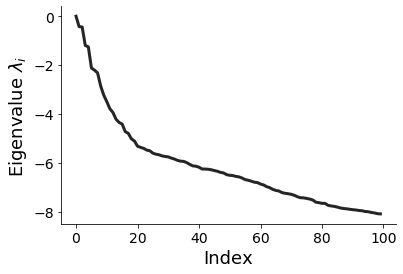

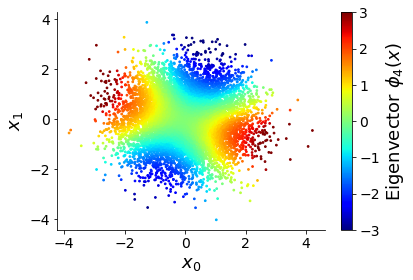

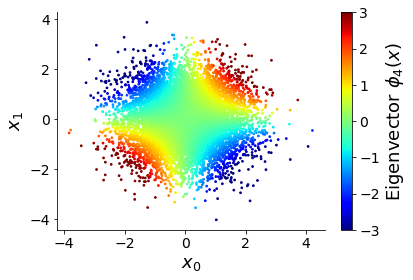

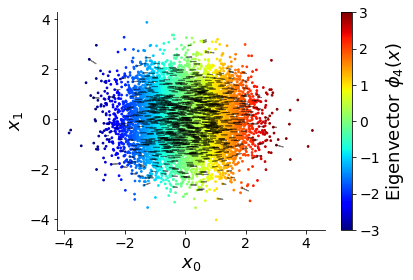

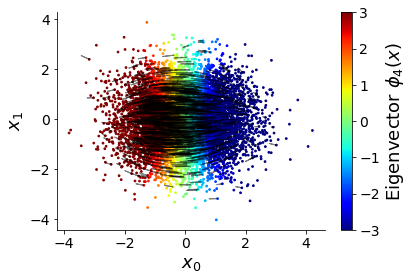

In [8]:
def PlotEigendecomposition():
    # compute the samples (this is a little redundant, but saves us having to store the samples as a variable)
    samples = [None]*n
    expectedEigenFunction = [None]*n
    for i in range(n):
        samples[i] = kolmogorov.Point(i)
        expectedEigenFunction[i] = samples[i][0]*samples[i][1]
        #expectedEigenFunction[i] = samples[i][0]*samples[i][0] - samples[i][1]*samples[i][1]
    samples = np.array(samples).T
    expectedEigenFunction = np.sqrt(n)*np.array(expectedEigenFunction)/np.linalg.norm(expectedEigenFunction)
    
    q4 = Qhat[:,4]
    q4 = np.diag(np.reciprocal(similarity))@q4
    q4 = np.sqrt(n)*q4/np.linalg.norm(q4)
            
    # plot the eigenvalues
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.plot(eigs, linewidth=3, color='#252525')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'Index')
    ax.set_ylabel(r'Eigenvalue $\lambda_i$')
    plt.show()
    
    # plot the eigenfunction estimate
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=q4, vmin=-3.0, vmax=3.0, cmap='jet')
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Eigenvector $\phi_4(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
    # plot the eigenfunction
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=expectedEigenFunction, vmin=-3.0, vmax=3.0, cmap='jet')
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Eigenvector $\phi_4(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
    # plot the right hand side and its gradient
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=rhs, vmin=-3.0, vmax=3.0, cmap='jet')
    scale = 0.2
    for i in range(min(1000, n)):
        ax.arrow(kolmogorov.Point(i) [0], kolmogorov.Point(i) [1], scale*rhsGrad[i, 0], scale*rhsGrad[i, 1], alpha=0.5)
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Eigenvector $\phi_4(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
    # plot the solution and its gradient
    %matplotlib inline
    fig = plt.figure()
    ax = plt.gca()
    scatter = ax.scatter(samples[0], samples[1], s=3, c=soln, vmin=-3.0, vmax=3.0, cmap='jet')
    scale = 0.2
    for i in range(min(1000, n)):
        ax.arrow(kolmogorov.Point(i) [0], kolmogorov.Point(i) [1], scale*solnGrad[i, 0], scale*solnGrad[i, 1], alpha=0.5)
    cbar = plt.colorbar(scatter)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_ylabel(r'Eigenvector $\phi_4(x)$')
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    plt.show()
    
PlotEigendecomposition()